In [ ]:
# ==============================
# Setup: Spark Session & Data Load
# ==============================
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, to_date, count, avg, date_format

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Start Spark session
spark = SparkSession.builder.appName("SIT742Assignment2").getOrCreate()

# Load CSVs
# reviews = spark.read.csv("./business_review_submission/review.csv", header=True, inferSchema=True)
# meta = spark.read.csv("./business_review_submission/meta-review-business.csv", header=True, inferSchema=True)

reviews = (
    spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
    .option("multiLine", "true")         # handles reviews spanning multiple lines
    .option("escape", "\"")              # handles quotes in text
    .option("mode", "PERMISSIVE")        # keep malformed rows instead of dropping
    .option("columnNameOfCorruptRecord", "_corrupt_record")  # optional: track bad rows
    .load("./business_review_submission/review.csv")
)

meta = (
    spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
    .option("mode", "PERMISSIVE")
    .load("./business_review_submission/meta-review-business.csv")
)

# Preview
reviews.printSchema()
meta.printSchema()


root
 |-- user_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- time: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- text: string (nullable = true)
 |-- pics: string (nullable = true)
 |-- resp: string (nullable = true)
 |-- gmap_id: string (nullable = true)

root
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- gmap_id: string (nullable = true)
 |-- description: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- category: string (nullable = true)
 |-- avg_rating: string (nullable = true)
 |-- num_of_reviews: string (nullable = true)
 |-- price: string (nullable = true)
 |-- hours: string (nullable = true)
 |-- MISC: string (nullable = true)
 |-- state: string (nullable = true)
 |-- relative_results: string (nullable = true)
 |-- url: string (nullable = true)



### Q1.1

In [26]:
from pyspark.sql.functions import col, when, from_unixtime

# Replace null text with "no review"
reviews = reviews.withColumn("text", when(col("text").isNull(), "no review").otherwise(col("text")))

# Convert Unix timestamp (milliseconds) into yyyy-MM-dd
reviews = reviews.withColumn("newtime", from_unixtime((col("time")/1000).cast("bigint"), "yyyy-MM-dd"))

# Show first 5 rows
reviews.select("user_id", "name", "time", "newtime", "rating", "text", "gmap_id").show(5, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------+-------------+----------+---------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------+
|user_id                                                                                                                                            |name                                               |time         |newtime   |rating                                                                                                      

### Q1.2

In [22]:
from pyspark.sql.functions import count

# Count number of reviews per gmap_id
review_counts = reviews.groupBy("gmap_id") \
    .agg(count("*").cast("float").alias("review_count"))

# Show top 5 rows
review_counts.show(5, truncate=False)


+-------------------------------------+------------+
|gmap_id                              |review_count|
+-------------------------------------+------------+
|0x56c8977642a793f5:0xab9f95aa9c585a46|24.0        |
|0x56c79c63a5af15e3:0x117ca44b9578b995|10.0        |
|0x56c8976e16705e63:0x787e5d94ea9d2387|49.0        |
|0x51325aac7a4434e5:0xfbed5197982b41ae|28.0        |
|0x56c6631e32190947:0x7620b39117ffbb62|12.0        |
+-------------------------------------+------------+
only showing top 5 rows



In [23]:
import pandas as pd

# Convert Spark DataFrame into Pandas
pdf = reviews.select("gmap_id", "time", "newtime", "text", "rating").toPandas()

# Convert Unix time (ms) into datetime
pdf["datetime"] = pd.to_datetime(pdf["time"], unit="ms", errors="coerce")

# Extract hour as review_time
pdf["review_time"] = pdf["datetime"].dt.hour

# Show first 5 rows
pdf.head()


/var/folders/dd/0tkhlwmx0_vds57k26pnqh7w0000gn/T/ipykernel_10253/3497942680.py:7: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  pdf["datetime"] = pd.to_datetime(pdf["time"], unit="ms", errors="coerce")


,gmap_id,time,newtime,text,rating,datetime,review_time
0,0x56b646ed2220b77f:0xd8975e316de80952,1566331951619,2019-08-21,We always stay here when in Valdez for silver ...,5,2019-08-20 20:12:31.619,20.0
1,0x56b646ed2220b77f:0xd8975e316de80952,1504917982385,2017-09-09,Great campground for the price. Nice hot unlim...,5,2017-09-09 00:46:22.385,0.0
2,None,1474765901185,2016-09-25,We tent camped here for 2 nights while explori...,4,2016-09-25 01:11:41.185,1.0
3,None,toilet,None,but they lack vent fans to remove moisture so...,shower). The hot water will run out after a f...,NaT,NaN
4,None,None,None,no review,0x56b646ed2220b77f:0xd8975e316de80952,NaT,NaN


/var/folders/dd/0tkhlwmx0_vds57k26pnqh7w0000gn/T/ipykernel_10253/4017756486.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf_clean["review_time"] = pdf_clean["review_time"].astype(int)
/var/folders/dd/0tkhlwmx0_vds57k26pnqh7w0000gn/T/ipykernel_10253/4017756486.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="review_time", data=pdf_clean, palette="viridis")


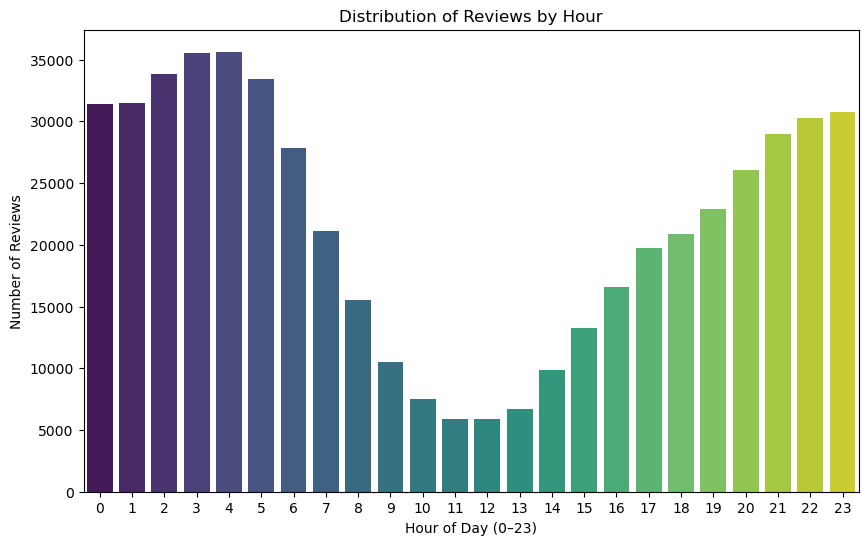

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop NaN values in review_time
pdf_clean = pdf.dropna(subset=["review_time"])

# Convert review_time to int (avoid float values like 20.0, 0.0, etc.)
pdf_clean["review_time"] = pdf_clean["review_time"].astype(int)

# Distribution of review times (hourly)
plt.figure(figsize=(10,6))
sns.countplot(x="review_time", data=pdf_clean, palette="viridis")
plt.title("Distribution of Reviews by Hour")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)  # keep hours horizontal
plt.show()



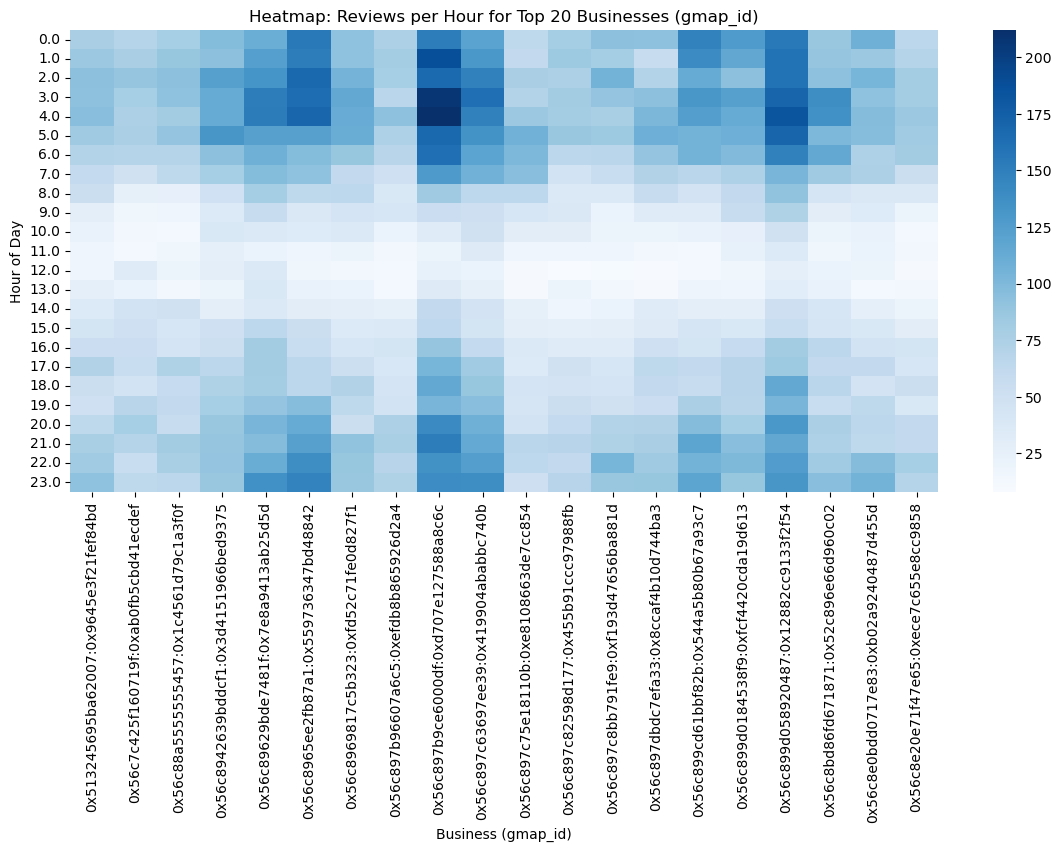

In [29]:
# Keep only rows where gmap_id looks valid (starts with '0x')
pdf_clean = pdf.dropna(subset=["review_time", "gmap_id"])
pdf_clean = pdf_clean[pdf_clean["gmap_id"].astype(str).str.startswith("0x")]

# Get top 20 businesses with most reviews
top_ids = pdf_clean["gmap_id"].value_counts().nlargest(20).index
pdf_top = pdf_clean[pdf_clean["gmap_id"].isin(top_ids)]

# Pivot for heatmap
pivot = pdf_top.pivot_table(
    index="review_time", 
    columns="gmap_id", 
    values="text", 
    aggfunc="count", 
    fill_value=0
)

plt.figure(figsize=(14,6))
sns.heatmap(pivot, cmap="Blues")
plt.title("Heatmap: Reviews per Hour for Top 20 Businesses (gmap_id)")
plt.xlabel("Business (gmap_id)")
plt.ylabel("Hour of Day")
plt.show()

